# SuperVoice vocoder evaluation
This notebook provides tools for customized Vocos evaluation

In [1]:
# Base
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Local
from model.vocoder import Vocoder
from model.dataset import load_mono_audio
from model.utils import hann_window, melscale_fbanks, resampler

### Environment

In [2]:
# Parameters
device = torch.device('cpu')

checkpoint = "./output/new_mel_2.pt"

# Device and Model
generator = Vocoder(n_mels=80).to(device)

# Load checkpoint
data = torch.load(checkpoint, map_location=device)
generator.load_state_dict(data['vocoder'])
generator.eval()

# Tools
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=(0,5)):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(15, 8))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_specgram(spectrogram, title="Spectrogram"):
    _, axis = plt.subplots(1, 1, figsize=(15, 8))
    axis.imshow(spectrogram, cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.tight_layout()

#
# Spectogram caclulcation
#

def spectogram(audio, n_fft, n_mels, n_hop, n_window, sample_rate):

    # Hann Window
    window = hann_window(n_window, audio.device)

    # STFT
    stft = torch.stft(audio, 
        n_fft, 
        hop_length=n_hop, 
        win_length=n_window,
        window=window, 
        return_complex=True
    )

    # Compute magnitudes using squared value
    # magnitudes = torch.sum((stft ** 2), dim=-1)[..., :-1]
    magnitudes = stft[..., :-1].abs()

    # Mel Log Bank
    mel_filters = melscale_fbanks(n_mels, n_fft, 0, sample_rate / 2, sample_rate, audio.device)
    mel_spec = (mel_filters @ magnitudes)

    # Log
    log_spec = torch.clamp(mel_spec, min=1e-10).log10()

    return log_spec


# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

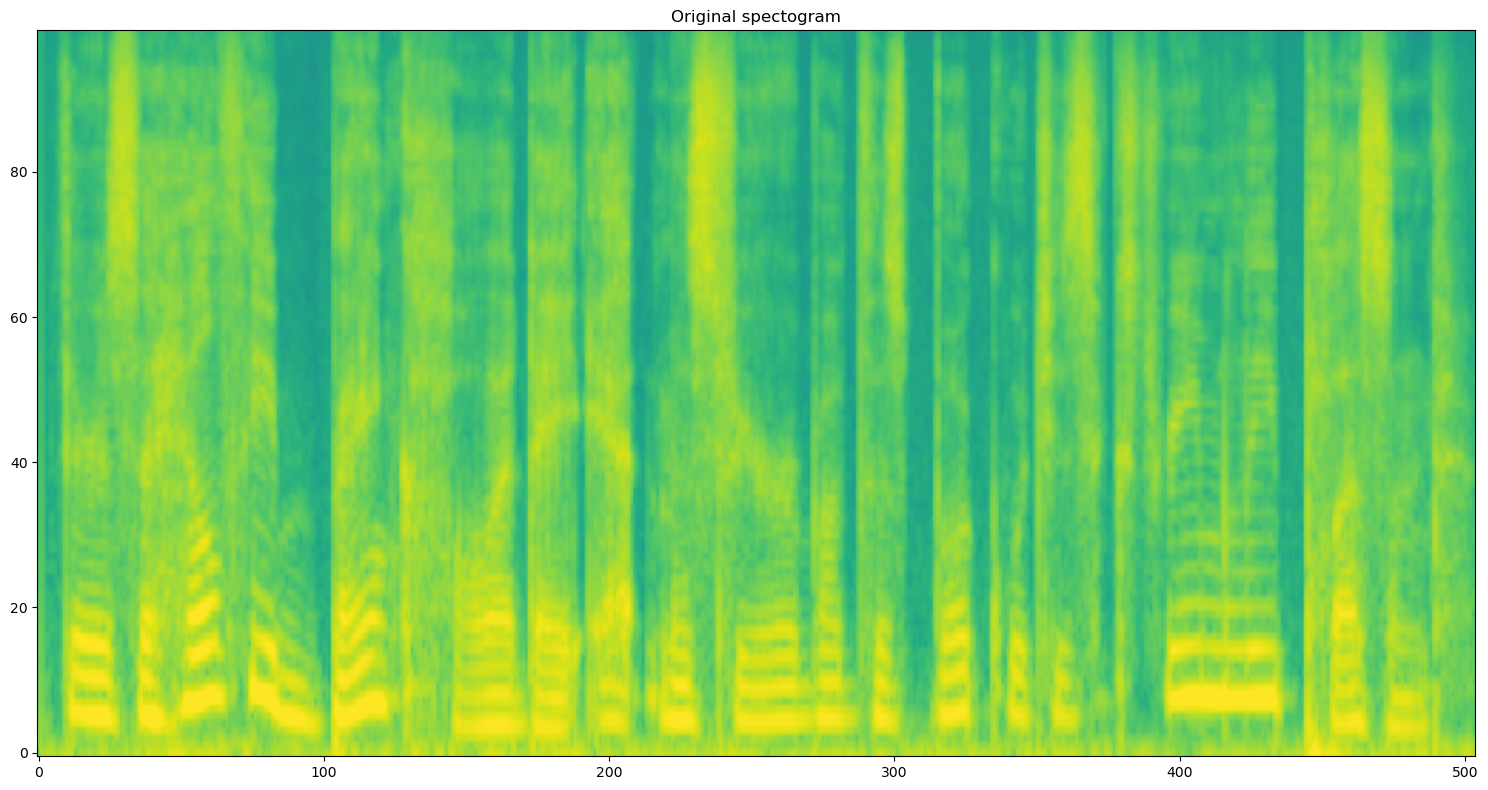

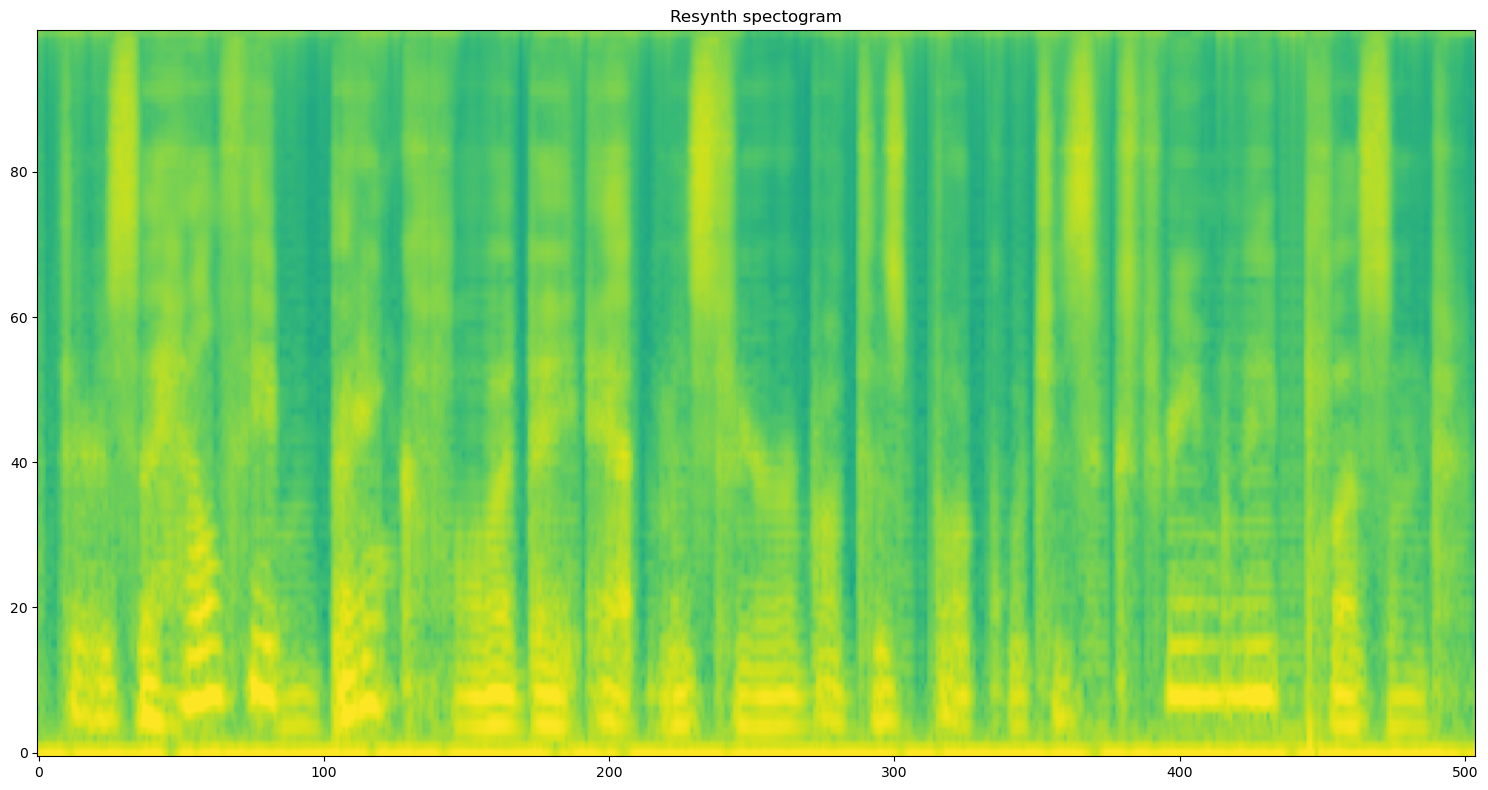

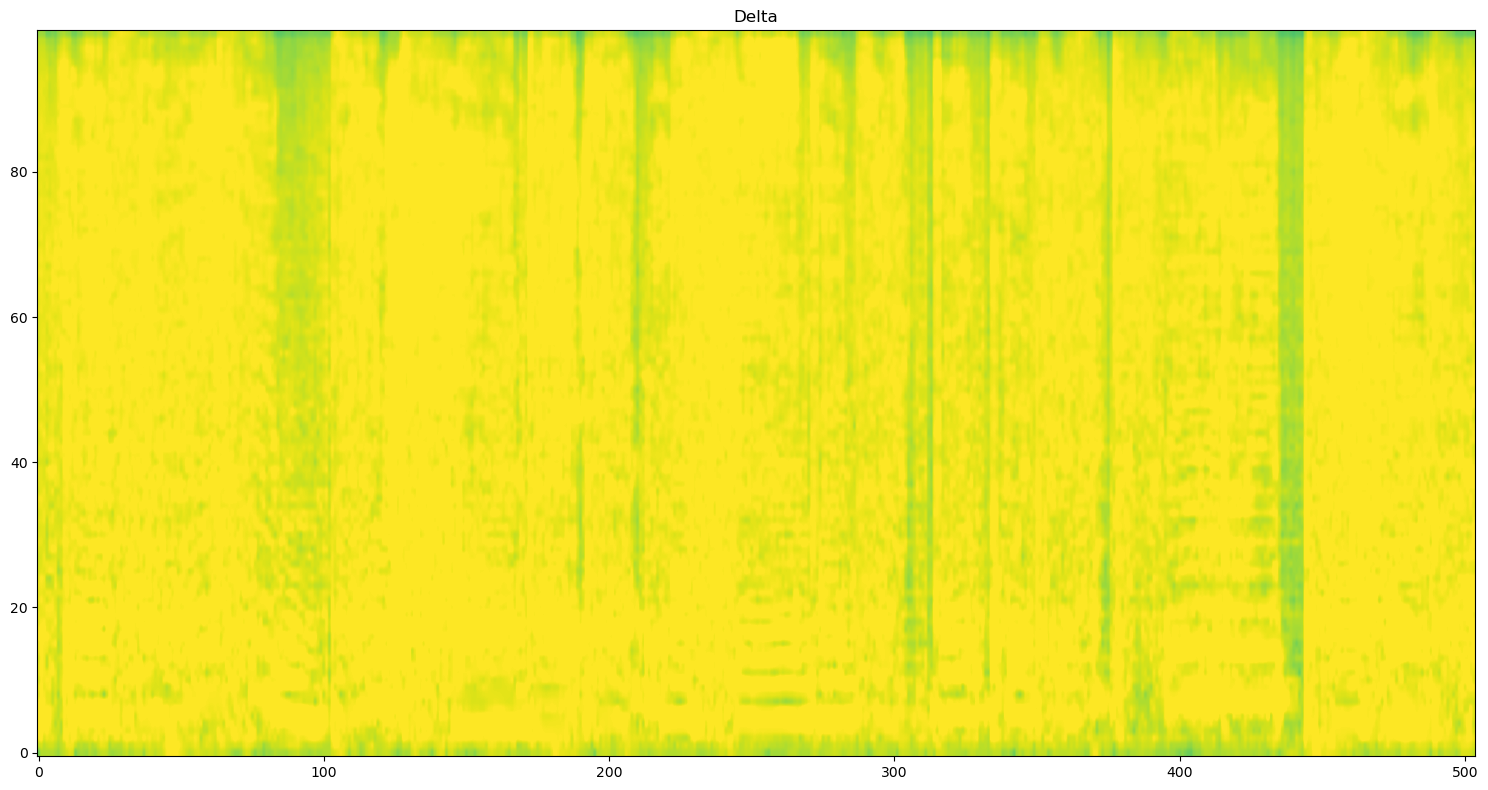

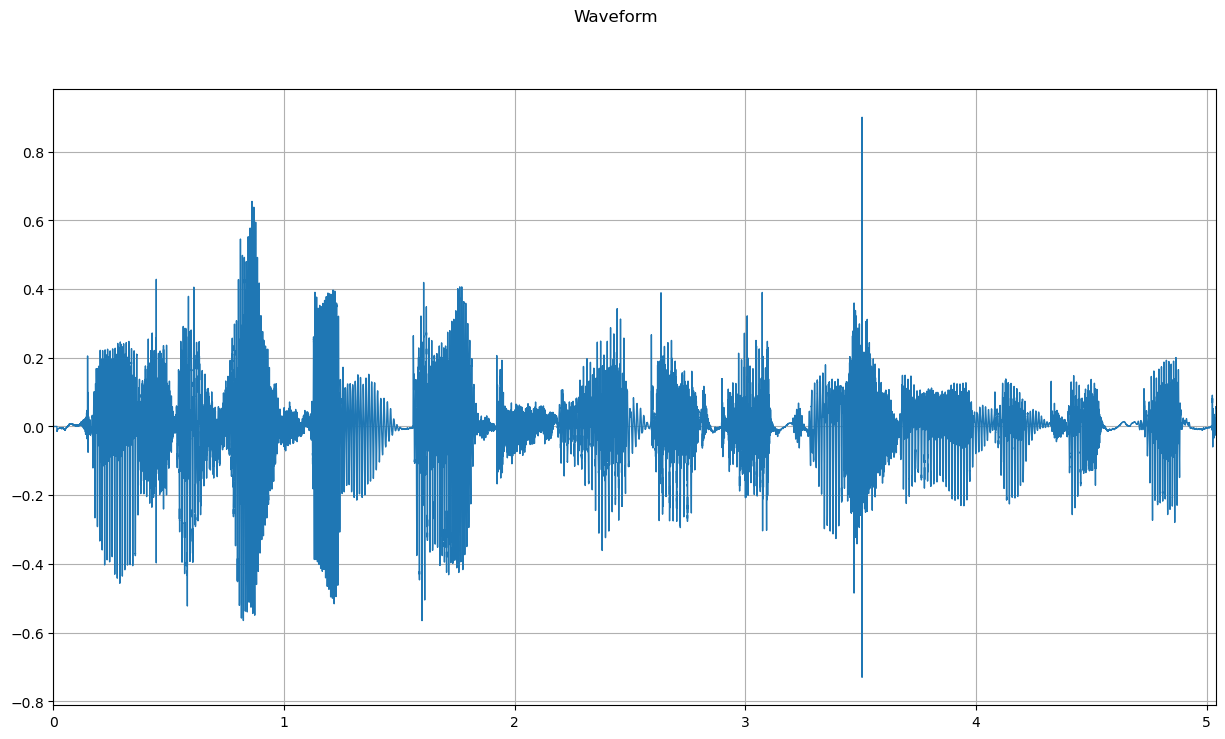

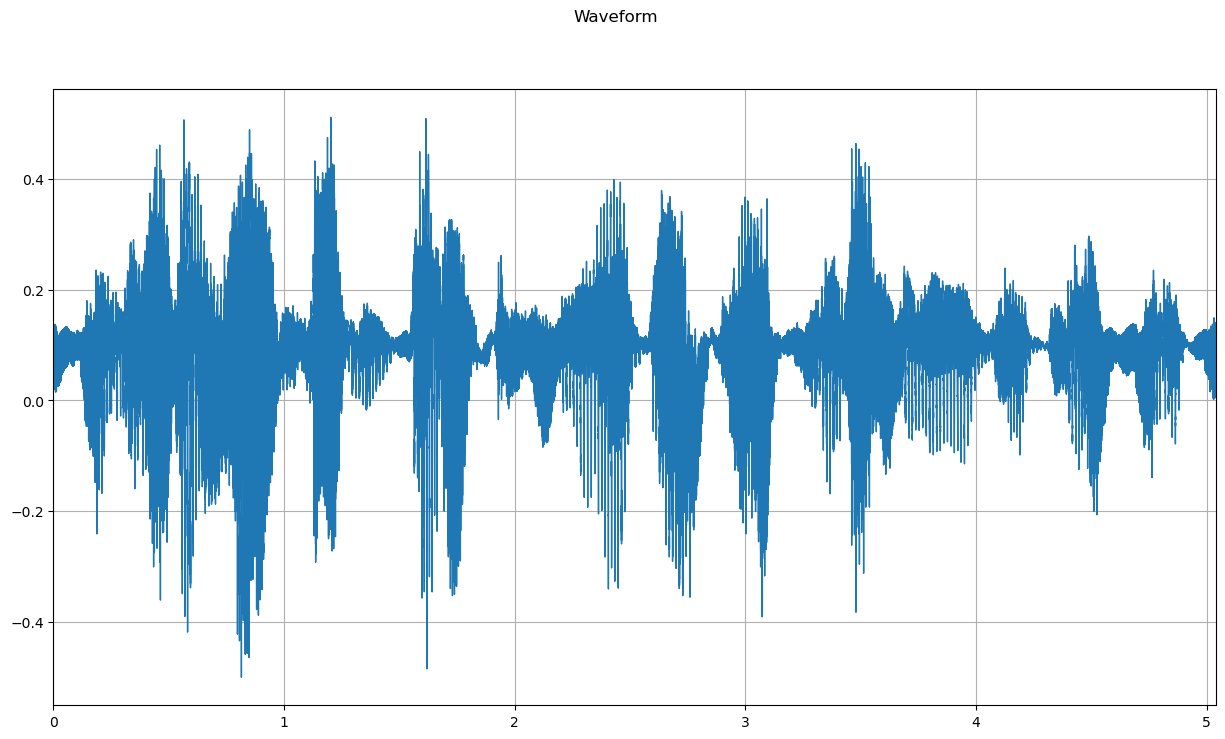

In [4]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", 24000)
else:
    test = load_mono_audio("./external_datasets/libritts-r/dev-clean/1272/128104/1272_128104_000003_000000.wav", 24000)
spec = spectogram(test, 1024, 100, 240, 240 * 4, 24000).squeeze(0)
spec_target = spectogram(resampler(24000, 16000)(test), 1024, 80, 16000 // 100, (16000 // 100) * 4, 16000)

# Generate
resynth = generator(spec_target.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
resynth_spec = spectogram(resynth, 1024, 100, 240, 240 * 4, 24000).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(resynth_spec, title="Resynth spectogram")
plot_specgram(spec - resynth_spec, title="Delta")
plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / 24000))
plot_waveform(resynth.unsqueeze(0),xlim=(0,len(test) / 24000))
display(Audio(data=test, rate=24000))
display(Audio(data=resynth, rate=24000))